### 1. Taking gradients with `jax.grad`
In JAX, you can differentiate a scalar-valued function with the `jax.grad()` transformation

In [1]:
import jax
import jax.numpy as jnp
from jax import grad

grad_tanh = grad(jnp.tanh)
print(grad_tanh(2.0))

0.070650816


`jax.grad()` takes a function and returns a function. If you have a Python function `f` that evaluates the mathematical function `f`, then `jax.grad(f)` is a Python function that evaluates the mathematical function `delta f`. That means `grad(f)(x)` represents the value `delta f(x)`.

Since `jax.grad()` operates on functions, you can apply it to its own output to differentiate as many times as you like

In [2]:
print(grad(grad(jnp.tanh))(2.0))
print(grad(grad(grad(jnp.tanh)))(2.0))

-0.13621868
0.25265405


In [3]:
f = lambda x: x**3 + 2*x**2 - 3*x + 1

dfdx = jax.grad(f)

In [4]:
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)

In [5]:
print(dfdx(1.))
print(d2fdx(1.))
print(d3fdx(1.))
print(d4fdx(1.))

4.0
10.0
6.0
0.0


### 2. Computing gradients in a linear logistic regression
The next example shows how to compute gradients with `jax.grad()` in a linear logistic regression model. First, the setup:

In [6]:
key = jax.random.key(0)

def sigmoid(x):
  return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
  return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                    [0.88, -1.08, 0.15],
                    [0.52, 0.06, -1.30],
                    [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])

# Training loss is the negative log-likelihood of the training examples.
def loss(W, b):
  preds = predict(W, b, inputs)
  label_probs = preds * targets + (1 - preds) * (1 - targets)
  return -jnp.sum(jnp.log(label_probs))

# Initialize random model coefficients
key, W_key, b_key = jax.random.split(key, 3)
W = jax.random.normal(W_key, (3,))
b = jax.random.normal(b_key, ())

In [7]:
# Differentiate `loss` with respect to the first positional argument:
W_grad = grad(loss, argnums=0)(W, b)
print(f'{W_grad=}')

# Since argnums=0 is the default, this does the same thing:
W_grad = grad(loss)(W, b)
print(f'{W_grad=}')

# But you can choose different values too, and drop the keyword:
b_grad = grad(loss, 1)(W, b)
print(f'{b_grad=}')

# Including tuple values
W_grad, b_grad = grad(loss, (0, 1))(W, b)
print(f'{W_grad=}')
print(f'{b_grad=}')

W_grad=Array([-0.16965583, -0.8774644 , -1.4901346 ], dtype=float32)
W_grad=Array([-0.16965583, -0.8774644 , -1.4901346 ], dtype=float32)
b_grad=Array(-0.29227245, dtype=float32)
W_grad=Array([-0.16965583, -0.8774644 , -1.4901346 ], dtype=float32)
b_grad=Array(-0.29227245, dtype=float32)


### 3. Differentiating with respect to nested lists, tuples, and dicts
Due to JAX’s PyTree abstraction, differentiating with respect to standard Python containers just works, so use tuples, lists, and dicts (and arbitrary nesting) however you like.

In [8]:
def loss2(params_dict):
    preds = predict(params_dict['W'], params_dict['b'], inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.sum(jnp.log(label_probs))

print(grad(loss2)({'W': W, 'b': b}))

{'W': Array([-0.16965583, -0.8774644 , -1.4901346 ], dtype=float32), 'b': Array(-0.29227245, dtype=float32)}


### 4. Evaluating a function and its gradient using `jax.value_and_grad`
Another convenient function is `jax.value_and_grad()` for efficiently computing both a function’s value as well as its gradient’s value in one pass.

In [9]:
loss_value, Wb_grad = jax.value_and_grad(loss, (0, 1))(W, b)
print('loss value', loss_value)
print('loss value', loss(W, b))

loss value 3.0519385
loss value 3.0519385


### 5. Checking against numerical differences
A great thing about derivatives is that they’re straightforward to check with finite differences.

In [10]:
# Set a step size for finite differences calculations
eps = 1e-4

# Check b_grad with scalar finite differences
b_grad_numerical = (loss(W, b + eps / 2.) - loss(W, b - eps / 2.)) / eps
print('b_grad_numerical', b_grad_numerical)
print('b_grad_autodiff', grad(loss, 1)(W, b))

# Check W_grad with finite differences in a random direction
key, subkey = jax.random.split(key)
vec = jax.random.normal(subkey, W.shape)
unitvec = vec / jnp.sqrt(jnp.vdot(vec, vec))
W_grad_numerical = (loss(W + eps / 2. * unitvec, b) - loss(W - eps / 2. * unitvec, b)) / eps
print('W_dirderiv_numerical', W_grad_numerical)
print('W_dirderiv_autodiff', jnp.vdot(grad(loss)(W, b), unitvec))

b_grad_numerical -0.29325485
b_grad_autodiff -0.29227245
W_dirderiv_numerical -0.2002716
W_dirderiv_autodiff -0.19909117


In [11]:
from jax.test_util import check_grads

check_grads(loss, (W, b), order=2)  # check up to 2nd order derivatives

## Advanced automatic differentiation

In [12]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.key(0)

In [13]:
def hessian(f):
  return jax.jacfwd(jax.grad(f))

In [14]:
def f(x):
  return jnp.dot(x, x)

hessian(f)(jnp.array([1., 2., 3.]))

Array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]], dtype=float32)

### Stopping gradients
Autodiff enables automatic computation of the gradient of a function with respect to its inputs. Sometimes, however, you might want some additional control: for instance, you might want to avoid backpropagating gradients through some subset of the computational graph.

In [15]:
# Value function and initial parameters
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

In [16]:
# An example transition.
s_tm1 = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0.])

In [17]:
def td_loss(theta, s_tm1, r_t, s_t):
  v_tm1 = value_fn(theta, s_tm1)
  target = r_t + value_fn(theta, s_t)
  return -0.5 * ((target - v_tm1) ** 2)

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

delta_theta

Array([-1.2,  1.2, -1.2], dtype=float32)

In [18]:
def td_loss(theta, s_tm1, r_t, s_t):
  v_tm1 = value_fn(theta, s_tm1)
  target = r_t + value_fn(theta, s_t)
  return -0.5 * ((jax.lax.stop_gradient(target) - v_tm1) ** 2)

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

delta_theta

Array([ 1.2,  2.4, -1.2], dtype=float32)

In [19]:
s_grad = jax.grad(value_fn)(theta, s_tm1)
delta_theta_original_calculation = (r_t + value_fn(theta, s_t) - value_fn(theta, s_tm1)) * s_grad

delta_theta_original_calculation # [1.2, 2.4, -1.2], same as `delta_theta`

Array([ 1.2,  2.4, -1.2], dtype=float32)

### Straight-through estimator using `stop_gradient`
The straight-through estimator is a trick for defining a ‘gradient’ of a function that is otherwise non-differentiable.

In [20]:
def f(x):
  return jnp.round(x)  # non-differentiable

def straight_through_f(x):
  # Create an exactly-zero expression with Sterbenz lemma that has
  # an exactly-one gradient.
  zero = x - jax.lax.stop_gradient(x)
  return zero + jax.lax.stop_gradient(f(x))

print("f(x): ", f(3.2))
print("straight_through_f(x):", straight_through_f(3.2))

print("grad(f)(x):", jax.grad(f)(3.2))
print("grad(straight_through_f)(x):", jax.grad(straight_through_f)(3.2))

f(x):  3.0
straight_through_f(x): 3.0
grad(f)(x): 0.0
grad(straight_through_f)(x): 1.0


#### Per-example gradients
While most ML systems compute gradients and updates from batches of data, for reasons of computational efficiency and/or variance reduction, it is sometimes necessary to have access to the gradient/update associated with each specific sample in the batch.

For instance, this is needed to prioritize data based on gradient magnitude, or to apply clipping / normalisations on a sample by sample basis.

In many frameworks (PyTorch, TF, Theano) it is often not trivial to compute per-example gradients, because the library directly accumulates the gradient over the batch. Naive workarounds, such as computing a separate loss per example and then aggregating the resulting gradients are typically very inefficient.

In JAX, you can define the code to compute the gradient per-sample in an easy but efficient way.

Just combine the `jax.jit()`, `jax.vmap()` and `jax.grad()` transformations together:

In [21]:
perex_grads = jax.jit(jax.vmap(jax.grad(td_loss), in_axes=(None, 0, 0, 0)))

# Test it:
batched_s_tm1 = jnp.stack([s_tm1, s_tm1])
batched_r_t = jnp.stack([r_t, r_t])
batched_s_t = jnp.stack([s_t, s_t])

perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

Array([[ 1.2,  2.4, -1.2],
       [ 1.2,  2.4, -1.2]], dtype=float32)

In [22]:
dtdloss_dtheta = jax.grad(td_loss)

dtdloss_dtheta(theta, s_tm1, r_t, s_t)

Array([ 1.2,  2.4, -1.2], dtype=float32)

In [23]:
almost_perex_grads = jax.vmap(dtdloss_dtheta)

batched_theta = jnp.stack([theta, theta])
almost_perex_grads(batched_theta, batched_s_tm1, batched_r_t, batched_s_t)

Array([[ 1.2,  2.4, -1.2],
       [ 1.2,  2.4, -1.2]], dtype=float32)

In [24]:
inefficient_perex_grads = jax.vmap(dtdloss_dtheta, in_axes=(None, 0, 0, 0))

inefficient_perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

Array([[ 1.2,  2.4, -1.2],
       [ 1.2,  2.4, -1.2]], dtype=float32)

In [25]:
perex_grads = jax.jit(inefficient_perex_grads)

perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

Array([[ 1.2,  2.4, -1.2],
       [ 1.2,  2.4, -1.2]], dtype=float32)

In [26]:
%timeit inefficient_perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t).block_until_ready()
%timeit perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t).block_until_ready()

5.42 ms ± 127 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.62 μs ± 446 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Hessian-vector products with `jax.grad`-of-`jax.grad`
One thing you can do with higher-order `jax.vmap()` is build a Hessian-vector product function. (Later on you’ll write an even more efficient implementation that mixes both forward- and reverse-mode, but this one will use pure reverse-mode.)

A Hessian-vector product function can be useful in a truncated Newton Conjugate-Gradient algorithm for minimizing smooth convex functions, or for studying the curvature of neural network training objectives

In [27]:
def hvp(f, x, v):
    return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)

### Jacobians and Hessians using `jax.jacfwd` and `jax.jacrev`
You can compute full Jacobian matrices using the `jax.jacfwd()` and `jax.jacrev()` functions:

In [28]:
from jax import jacfwd, jacrev

# Define a sigmoid function.
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])

# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

J = jacfwd(f)(W)
print("jacfwd result, with shape", J.shape)
print(J)

J = jacrev(f)(W)
print("jacrev result, with shape", J.shape)
print(J)

jacfwd result, with shape (4, 3)
[[ 0.05981758  0.12883787  0.08857603]
 [ 0.04015916 -0.04928625  0.00684531]
 [ 0.12188288  0.01406341 -0.3047072 ]
 [ 0.00140431 -0.00472531  0.00263782]]
jacrev result, with shape (4, 3)
[[ 0.05981757  0.12883787  0.08857603]
 [ 0.04015916 -0.04928625  0.00684531]
 [ 0.12188289  0.01406341 -0.3047072 ]
 [ 0.00140431 -0.00472531  0.00263782]]


In [29]:
def predict_dict(params, inputs):
    return predict(params['W'], params['b'], inputs)

J_dict = jacrev(predict_dict)({'W': W, 'b': b}, inputs)
for k, v in J_dict.items():
    print("Jacobian from {} to logits is".format(k))
    print(v)

Jacobian from W to logits is
[[ 0.05981757  0.12883787  0.08857603]
 [ 0.04015916 -0.04928625  0.00684531]
 [ 0.12188289  0.01406341 -0.3047072 ]
 [ 0.00140431 -0.00472531  0.00263782]]
Jacobian from b to logits is
[0.11503381 0.04563541 0.23439017 0.00189771]


In [30]:
def hessian(f):
    return jacfwd(jacrev(f))

H = hessian(f)(W)
print("hessian, with shape", H.shape)
print(H)

hessian, with shape (4, 3, 3)
[[[ 0.02285465  0.04922541  0.03384247]
  [ 0.04922541  0.10602397  0.07289147]
  [ 0.03384247  0.07289147  0.05011288]]

 [[-0.03195215  0.03921401 -0.00544639]
  [ 0.03921401 -0.04812629  0.00668421]
  [-0.00544639  0.00668421 -0.00092836]]

 [[-0.01583708 -0.00182736  0.03959271]
  [-0.00182736 -0.00021085  0.00456839]
  [ 0.03959271  0.00456839 -0.09898177]]

 [[-0.00103524  0.00348343 -0.00194457]
  [ 0.00348343 -0.01172127  0.0065432 ]
  [-0.00194457  0.0065432  -0.00365263]]]


## How it’s made: Two foundational autodiff functions
### Jacobian-Vector products (JVPs, a.k.a. forward-mode autodiff)
JAX includes efficient and general implementations of both forward- and reverse-mode automatic differentiation. The familiar `jax.vmap()` function is built on reverse-mode, but to explain the difference between the two modes, and when each can be useful, you need a bit of math background.

### JVPs in JAX code
Back in Python code, JAX’s `jax.jvp()` function models this transformation. Given a Python function that evaluates `f`, JAX’s `jax.jvp()` is a way to get a Python function for evaluatin

In [31]:
from jax import jvp

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

key, subkey = random.split(key)
v = random.normal(subkey, W.shape)

# Push forward the vector `v` along `f` evaluated at `W`
y, u = jvp(f, (W,), (v,))

### Vector-Jacobian products (VJPs, a.k.a. reverse-mode autodiff)
Where forward-mode gives us back a function for evaluating Jacobian-vector products, which we can then use to build Jacobian matrices one column at a time, reverse-mode is a way to get back a function for evaluating vector-Jacobian products (equivalently Jacobian-transpose-vector products), which we can use to build Jacobian matrices one row at a time.

### VJPs in JAX code
Switching from math back to Python, the JAX function vjp can take a Python function for evaluating ``f` and give us back a Python function for evaluating the VJP

In [32]:
from jax import vjp

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

y, vjp_fun = vjp(f, W)

key, subkey = random.split(key)
u = random.normal(subkey, y.shape)

# Pull back the covector `u` along `f` evaluated at `W`
v = vjp_fun(u)

## Vector-valued gradients with VJPs

In [33]:
def vgrad(f, x):
  y, vjp_fn = vjp(f, x)
  return vjp_fn(jnp.ones(y.shape))[0]

print(vgrad(lambda x: 3*x**2, jnp.ones((2, 2))))

[[6. 6.]
 [6. 6.]]


## Hessian-vector products using both forward- and reverse-mode
In a previous section, you implemented a Hessian-vector product function just using reverse-mode (assuming continuous second derivatives):

In [34]:
def hvp(f, x, v):
    return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)

In [35]:
# forward-over-reverse
def hvp(f, primals, tangents):
  return jvp(grad(f), primals, tangents)[1]

In [36]:
def f(X):
  return jnp.sum(jnp.tanh(X)**2)

key, subkey1, subkey2 = random.split(key, 3)
X = random.normal(subkey1, (30, 40))
V = random.normal(subkey2, (30, 40))

ans1 = hvp(f, (X,), (V,))
ans2 = jnp.tensordot(hessian(f)(X), V, 2)

print(jnp.allclose(ans1, ans2, 1e-4, 1e-4))

True


In [37]:
# Reverse-over-forward
def hvp_revfwd(f, primals, tangents):
  g = lambda primals: jvp(f, primals, tangents)[1]
  return grad(g)(primals)

In [38]:
# Reverse-over-reverse, only works for single arguments
def hvp_revrev(f, primals, tangents):
  x, = primals
  v, = tangents
  return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)


print("Forward over reverse")
%timeit -n10 -r3 hvp(f, (X,), (V,))
print("Reverse over forward")
%timeit -n10 -r3 hvp_revfwd(f, (X,), (V,))
print("Reverse over reverse")
%timeit -n10 -r3 hvp_revrev(f, (X,), (V,))

print("Naive full Hessian materialization")
%timeit -n10 -r3 jnp.tensordot(hessian(f)(X), V, 2)

Forward over reverse
4.36 ms ± 947 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Reverse over forward
9.18 ms ± 5.74 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Reverse over reverse
12.7 ms ± 7.98 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Naive full Hessian materialization
21.6 ms ± 1.24 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


## Composing VJPs, JVPs, and `jax.vmap`
### Jacobian-Matrix and Matrix-Jacobian products
Now that you have `jax.jvp()` and `jax.vjp()` transformations that give you functions to push-forward or pull-back single vectors at a time, you can use JAX’s `jax.vmap()` transformation to push and pull entire bases at once. In particular, you can use that to write fast matrix-Jacobian and Jacobian-matrix products:

In [39]:
# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

# Pull back the covectors `m_i` along `f`, evaluated at `W`, for all `i`.
# First, use a list comprehension to loop over rows in the matrix M.
def loop_mjp(f, x, M):
    y, vjp_fun = vjp(f, x)
    return jnp.vstack([vjp_fun(mi) for mi in M])

# Now, use vmap to build a computation that does a single fast matrix-matrix
# multiply, rather than an outer loop over vector-matrix multiplies.
def vmap_mjp(f, x, M):
    y, vjp_fun = vjp(f, x)
    outs, = vmap(vjp_fun)(M)
    return outs

key = random.key(0)
num_covecs = 128
U = random.normal(key, (num_covecs,) + y.shape)

loop_vs = loop_mjp(f, W, M=U)
print('Non-vmapped Matrix-Jacobian product')
%timeit -n10 -r3 loop_mjp(f, W, M=U)

print('\nVmapped Matrix-Jacobian product')
vmap_vs = vmap_mjp(f, W, M=U)
%timeit -n10 -r3 vmap_mjp(f, W, M=U)

assert jnp.allclose(loop_vs, vmap_vs), 'Vmap and non-vmapped Matrix-Jacobian Products should be identical'

C:\Users\devanshu.tayal\AppData\Local\Temp\ipykernel_8492\3769736790.py:8: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'tuple'> at position 0. In a future JAX release this will be an error.
  return jnp.vstack([vjp_fun(mi) for mi in M])


Non-vmapped Matrix-Jacobian product
176 ms ± 219 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)

Vmapped Matrix-Jacobian product
4.68 ms ± 75.5 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [40]:
def loop_jmp(f, W, M):
    # jvp immediately returns the primal and tangent values as a tuple,
    # so we'll compute and select the tangents in a list comprehension
    return jnp.vstack([jvp(f, (W,), (mi,))[1] for mi in M])

def vmap_jmp(f, W, M):
    _jvp = lambda s: jvp(f, (W,), (s,))[1]
    return vmap(_jvp)(M)

num_vecs = 128
S = random.normal(key, (num_vecs,) + W.shape)

loop_vs = loop_jmp(f, W, M=S)
print('Non-vmapped Jacobian-Matrix product')
%timeit -n10 -r3 loop_jmp(f, W, M=S)
vmap_vs = vmap_jmp(f, W, M=S)
print('\nVmapped Jacobian-Matrix product')
%timeit -n10 -r3 vmap_jmp(f, W, M=S)

assert jnp.allclose(loop_vs, vmap_vs), 'Vmap and non-vmapped Jacobian-Matrix products should be identical'

Non-vmapped Jacobian-Matrix product
200 ms ± 15.5 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)

Vmapped Jacobian-Matrix product
2.78 ms ± 744 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)


### The implementation of `jax.jacfwd` and `jax.jacrev`
Now that we’ve seen fast Jacobian-matrix and matrix-Jacobian products, it’s not hard to guess how to write `jax.jacfwd()` and `jax.jacrev()`. We just use the same technique to push-forward or pull-back an entire standard basis (isomorphic to an identity matrix) at once.

In [41]:
from jax import jacrev as builtin_jacrev

def our_jacrev(f):
    def jacfun(x):
        y, vjp_fun = vjp(f, x)
        # Use vmap to do a matrix-Jacobian product.
        # Here, the matrix is the Euclidean basis, so we get all
        # entries in the Jacobian at once.
        J, = vmap(vjp_fun, in_axes=0)(jnp.eye(len(y)))
        return J
    return jacfun

assert jnp.allclose(builtin_jacrev(f)(W), our_jacrev(f)(W)), 'Incorrect reverse-mode Jacobian results!'

In [42]:
from jax import jacfwd as builtin_jacfwd

def our_jacfwd(f):
    def jacfun(x):
        _jvp = lambda s: jvp(f, (x,), (s,))[1]
        Jt = vmap(_jvp, in_axes=1)(jnp.eye(len(x)))
        return jnp.transpose(Jt)
    return jacfun

assert jnp.allclose(builtin_jacfwd(f)(W), our_jacfwd(f)(W)), 'Incorrect forward-mode Jacobian results!'

In [43]:
def f(x):
    try:
        if x < 3:
            return 2 * x ** 3
        else:
            raise ValueError
    except ValueError:
        return jnp.pi * x

y, f_vjp = vjp(f, 4.)
print(jit(f_vjp)(1.))

(Array(3.1415927, dtype=float32, weak_type=True),)


## Complex numbers and differentiation
JAX is great at complex numbers and differentiation. To support both holomorphic and non-holomorphic differentiation, it helps to think in terms of JVPs and VJPs.

In [44]:
def f(z):
  x, y = jnp.real(z), jnp.imag(z)
  return u(x, y) + v(x, y) * 1j

def g(x, y):
  return (u(x, y), v(x, y))

In [45]:
def check(seed):
  key = random.key(seed)

  # random coeffs for u and v
  key, subkey = random.split(key)
  a, b, c, d = random.uniform(subkey, (4,))

  def fun(z):
    x, y = jnp.real(z), jnp.imag(z)
    return u(x, y) + v(x, y) * 1j

  def u(x, y):
    return a * x + b * y

  def v(x, y):
    return c * x + d * y

  # primal point
  key, subkey = random.split(key)
  x, y = random.uniform(subkey, (2,))
  z = x + y * 1j

  # tangent vector
  key, subkey = random.split(key)
  c, d = random.uniform(subkey, (2,))
  z_dot = c + d * 1j

  # check jvp
  _, ans = jvp(fun, (z,), (z_dot,))
  expected = (grad(u, 0)(x, y) * c +
              grad(u, 1)(x, y) * d +
              grad(v, 0)(x, y) * c * 1j+
              grad(v, 1)(x, y) * d * 1j)
  print(jnp.allclose(ans, expected))

check(0)
check(1)
check(2)

True
True
True


In [46]:
def check(seed):
  key = random.key(seed)

  # random coeffs for u and v
  key, subkey = random.split(key)
  a, b, c, d = random.uniform(subkey, (4,))

  def fun(z):
    x, y = jnp.real(z), jnp.imag(z)
    return u(x, y) + v(x, y) * 1j

  def u(x, y):
    return a * x + b * y

  def v(x, y):
    return c * x + d * y

  # primal point
  key, subkey = random.split(key)
  x, y = random.uniform(subkey, (2,))
  z = x + y * 1j

  # cotangent vector
  key, subkey = random.split(key)
  c, d = random.uniform(subkey, (2,))
  z_bar = jnp.array(c + d * 1j)  # for dtype control

  # check vjp
  _, fun_vjp = vjp(fun, z)
  ans, = fun_vjp(z_bar)
  expected = (grad(u, 0)(x, y) * c +
              grad(v, 0)(x, y) * (-d) +
              grad(u, 1)(x, y) * c * (-1j) +
              grad(v, 1)(x, y) * (-d) * (-1j))
  assert jnp.allclose(ans, expected, atol=1e-5, rtol=1e-5)

In [47]:
def f(z):
  x, y = jnp.real(z), jnp.imag(z)
  return x**2 + y**2

z = 3. + 4j
grad(f)(z)

Array(6.-8.j, dtype=complex64)

In [48]:
def f(z):
  return jnp.sin(z)

z = 3. + 4j
grad(f, holomorphic=True)(z)

Array(-27.034946-3.8511534j, dtype=complex64, weak_type=True)

In [49]:
def f(z):
  return jnp.conjugate(z)

z = 3. + 4j
grad(f, holomorphic=True)(z)  # f is not actually holomorphic!

Array(1.-0.j, dtype=complex64, weak_type=True)

In [50]:
A = jnp.array([[5.,    2.+3j,    5j],
              [2.-3j,   7.,  1.+7j],
              [-5j,  1.-7j,    12.]])

def f(X):
    L = jnp.linalg.cholesky(X)
    return jnp.sum((L - jnp.sin(L))**2)

grad(f, holomorphic=True)(A)

Array([[-0.7534186  +0.j       , -3.0509028 -10.940545j ,
         5.9896846  +3.5423026j],
       [-3.0509028 +10.940545j , -8.904491   +0.j       ,
        -5.1351523  -6.559373j ],
       [ 5.9896846  -3.5423026j, -5.1351523  +6.559373j ,
         0.01320427 +0.j       ]], dtype=complex64)

## Custom derivative rules for JAX-transformable Python functions
There are two ways to define differentiation rules in JAX:

1. Using `jax.custom_jvp()` and `jax.custom_vjp()` to define custom differentiation rules for Python functions that are already JAX-transformable; and

2. Defining new `core.Primitive` instances along with all their transformation rules, for example to call into functions from other systems like solvers, simulators, or general numerical    computing systems.

### TL;DR: Custom JVPs with `jax.custom_jvp()`

In [51]:
from jax import custom_jvp

@custom_jvp
def f(x, y):
  return jnp.sin(x) * y

@f.defjvp
def f_jvp(primals, tangents):
  x, y = primals
  x_dot, y_dot = tangents
  primal_out = f(x, y)
  tangent_out = jnp.cos(x) * x_dot * y + jnp.sin(x) * y_dot
  return primal_out, tangent_out

In [52]:
print(f(2., 3.))
y, y_dot = jvp(f, (2., 3.), (1., 0.))
print(y)
print(y_dot)
print(grad(f)(2., 3.))

2.7278922
2.7278922
-1.2484405
-1.2484405


In [53]:
# Equivalent alternative using the `defjvps` convenience wrapper

@custom_jvp
def f(x, y):
  return jnp.sin(x) * y

f.defjvps(lambda x_dot, primal_out, x, y: jnp.cos(x) * x_dot * y,
          lambda y_dot, primal_out, x, y: jnp.sin(x) * y_dot)

In [54]:
print(f(2., 3.))
y, y_dot = jvp(f, (2., 3.), (1., 0.))
print(y)
print(y_dot)
print(grad(f)(2., 3.))

2.7278922
2.7278922
-1.2484405
-1.2484405


### TL;DR: Custom VJPs with `jax.custom_vjp`

In [ ]:
from jax import custom_vjp

@custom_vjp
def f(x, y):
  return jnp.sin(x) * y

def f_fwd(x, y):
# Returns primal output and residuals to be used in backward pass by `f_bwd`.
  return f(x, y), (jnp.cos(x), jnp.sin(x), y)

def f_bwd(res, g):
  cos_x, sin_x, y = res # Gets residuals computed in `f_fwd`
  return (cos_x * g * y, sin_x * g)

f.defvjp(f_fwd, f_bwd)

print(grad(f)(2., 3.))

-1.2484405


In [56]:
def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

log1pexp(3.)

Array(3.0485873, dtype=float32, weak_type=True)

In [57]:
print(jit(log1pexp)(3.))
print(jit(grad(log1pexp))(3.))
print(vmap(jit(grad(log1pexp)))(jnp.arange(3.)))

3.0485873
0.95257413
[0.5       0.7310586 0.8807971]


In [58]:
print(grad(log1pexp)(100.))

nan


In [59]:
from jax import make_jaxpr

make_jaxpr(grad(log1pexp))(100.)

{ lambda ; a:f32[]. let
    b:f32[] = exp a
    c:f32[] = add 1.0 b
    _:f32[] = log c
    d:f32[] = div 1.0 c
    e:f32[] = mul d b
  in (e,) }

In [60]:
@custom_jvp
def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

@log1pexp.defjvp
def log1pexp_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = log1pexp(x)
  ans_dot = (1 - 1/(1 + jnp.exp(x))) * x_dot
  return ans, ans_dot

print(grad(log1pexp)(100.))

1.0


In [61]:
print(jit(log1pexp)(3.))
print(jit(grad(log1pexp))(3.))
print(vmap(jit(grad(log1pexp)))(jnp.arange(3.)))

3.0485873
0.95257413
[0.5       0.7310586 0.8807971]


In [62]:
@custom_jvp
def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

log1pexp.defjvps(lambda t, ans, x: (1 - 1/(1 + jnp.exp(x))) * t)

print(grad(log1pexp)(100.))
print(jit(log1pexp)(3.))
print(jit(grad(log1pexp))(3.))
print(vmap(jit(grad(log1pexp)))(jnp.arange(3.)))

1.0
3.0485873
0.95257413
[0.5       0.7310586 0.8807971]


In [63]:
def f(x):
  return x / (1 + jnp.sqrt(x))

print(grad(f)(0.))

nan


In [64]:
@custom_jvp
def f(x):
  return x / (1 + jnp.sqrt(x))

@f.defjvp
def f_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = f(x)
  ans_dot = ((jnp.sqrt(x) + 2) / (2 * (jnp.sqrt(x) + 1)**2)) * x_dot
  return ans, ans_dot

print(grad(f)(0.))

1.0


In [65]:
@custom_jvp
def f(x):
  return x / (1 + jnp.sqrt(x))

f.defjvps(lambda t, ans, x: ((jnp.sqrt(x) + 2) / (2 * (jnp.sqrt(x) + 1)**2)) * t)

print(grad(f)(0.))

1.0


In [66]:
from functools import partial

@custom_vjp
def clip_gradient(lo, hi, x):
  return x  # identity function

def clip_gradient_fwd(lo, hi, x):
  return x, (lo, hi)  # save bounds as residuals

def clip_gradient_bwd(res, g):
  lo, hi = res
  return (None, None, jnp.clip(g, lo, hi))  # use None to indicate zero cotangents for lo and hi

clip_gradient.defvjp(clip_gradient_fwd, clip_gradient_bwd)

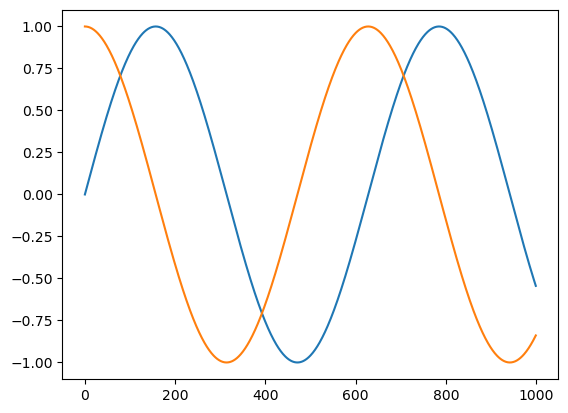

In [67]:
import matplotlib.pyplot as plt

t = jnp.linspace(0, 10, 1000)

plt.plot(jnp.sin(t))
plt.plot(vmap(grad(jnp.sin))(t))

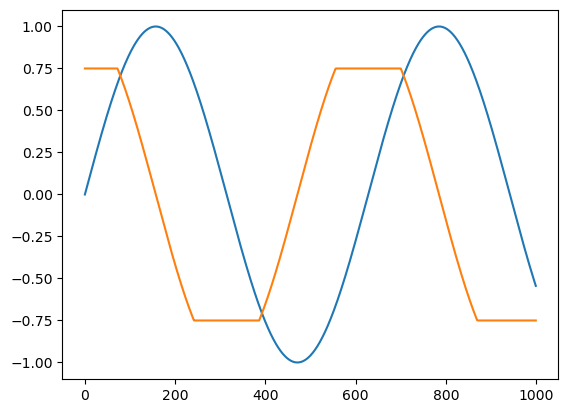

In [68]:
def clip_sin(x):
  x = clip_gradient(-0.75, 0.75, x)
  return jnp.sin(x)

plt.plot(clip_sin(t))
plt.plot(vmap(grad(clip_sin))(t))

In [69]:
from jax.lax import while_loop

def fixed_point(f, a, x_guess):
  def cond_fun(carry):
    x_prev, x = carry
    return jnp.abs(x_prev - x) > 1e-6

  def body_fun(carry):
    _, x = carry
    return x, f(a, x)

  _, x_star = while_loop(cond_fun, body_fun, (x_guess, f(a, x_guess)))
  return x_star

In [70]:
def newton_sqrt(a):
  update = lambda a, x: 0.5 * (x + a / x)
  return fixed_point(update, a, a)

print(newton_sqrt(2.))

1.4142135


In [71]:
print(jit(vmap(newton_sqrt))(jnp.array([1., 2., 3., 4.])))

[1.        1.4142135 1.7320509 2.       ]


In [72]:
@partial(custom_vjp, nondiff_argnums=(0,))
def fixed_point(f, a, x_guess):
  def cond_fun(carry):
    x_prev, x = carry
    return jnp.abs(x_prev - x) > 1e-6

  def body_fun(carry):
    _, x = carry
    return x, f(a, x)

  _, x_star = while_loop(cond_fun, body_fun, (x_guess, f(a, x_guess)))
  return x_star

def fixed_point_fwd(f, a, x_init):
  x_star = fixed_point(f, a, x_init)
  return x_star, (a, x_star)

def fixed_point_rev(f, res, x_star_bar):
  a, x_star = res
  _, vjp_a = vjp(lambda a: f(a, x_star), a)
  a_bar, = vjp_a(fixed_point(partial(rev_iter, f),
                             (a, x_star, x_star_bar),
                             x_star_bar))
  return a_bar, jnp.zeros_like(x_star)
  
def rev_iter(f, packed, u):
  a, x_star, x_star_bar = packed
  _, vjp_x = vjp(lambda x: f(a, x), x_star)
  return x_star_bar + vjp_x(u)[0]

fixed_point.defvjp(fixed_point_fwd, fixed_point_rev)

print(newton_sqrt(2.))

1.4142135


In [73]:
print(grad(newton_sqrt)(2.))
print(grad(grad(newton_sqrt))(2.))

0.35355338
-0.088388346


In [74]:
print(grad(jnp.sqrt)(2.))
print(grad(grad(jnp.sqrt))(2.))

0.35355338
-0.08838835


## Basic usage of `jax.custom_jvp` and `jax.custom_vjp` APIs
### Use jax.custom_jvp to define forward-mode (and, indirectly, reverse-mode) rules
Here’s a canonical basic example of using `jax.custom_jvp()`, where the comments use Haskell-like type signatures:

In [75]:
# f :: a -> b
@custom_jvp
def f(x):
  return jnp.sin(x)

# f_jvp :: (a, T a) -> (b, T b)
def f_jvp(primals, tangents):
  x, = primals
  t, = tangents
  return f(x), jnp.cos(x) * t

f.defjvp(f_jvp)

<function __main__.f_jvp(primals, tangents)>

In [76]:
print(f(3.))

y, y_dot = jvp(f, (3.,), (1.,))
print(y)
print(y_dot)

0.14112
0.14112
-0.9899925


In [77]:
@custom_jvp
def f(x):
  ...

@f.defjvp
def f_jvp(primals, tangents):
  ...

In [78]:
@custom_jvp
def f(x, y):
  return x ** 2 * y

@f.defjvp
def f_jvp(primals, tangents):
  x, y = primals
  x_dot, y_dot = tangents
  primal_out = f(x, y)
  tangent_out = 2 * x * y * x_dot + x ** 2 * y_dot
  return primal_out, tangent_out

print(grad(f)(2., 3.))

12.0


In [79]:
@custom_jvp
def f(x):
  return jnp.sin(x)

f.defjvps(lambda t, ans, x: jnp.cos(x) * t)

print(grad(f)(3.))

-0.9899925


In [80]:
@custom_jvp
def f(x, y):
  return x ** 2 * y

f.defjvps(lambda x_dot, primal_out, x, y: 2 * x * y * x_dot,
          lambda y_dot, primal_out, x, y: x ** 2 * y_dot)


print(grad(f)(2., 3.))
print(grad(f, 0)(2., 3.))  # same as above
print(grad(f, 1)(2., 3.))

12.0
12.0
4.0


In [81]:
@custom_jvp
def f(x, y):
  return x ** 2 * y

f.defjvps(lambda x_dot, primal_out, x, y: 2 * x * y * x_dot,
          None)

print(grad(f)(2., 3.))
print(grad(f, 0)(2., 3.))  # same as above
print(grad(f, 1)(2., 3.))

12.0
12.0
0.0


In [82]:
@custom_jvp
def f(x):
  print('called f!')  # a harmless side-effect
  return jnp.sin(x)

@f.defjvp
def f_jvp(primals, tangents):
  print('called f_jvp!')  # a harmless side-effect
  x, = primals
  t, = tangents
  return f(x), jnp.cos(x) * t

print(f(3.))

called f!
0.14112


In [83]:
print(vmap(f)(jnp.arange(3.)))
print(jit(f)(3.))

called f!
[0.         0.84147096 0.9092974 ]
called f!
0.14112


In [84]:
y, y_dot = jvp(f, (3.,), (1.,))
print(y_dot)

called f_jvp!
called f!
-0.9899925


In [85]:
print(grad(f)(3.))

called f_jvp!
called f!
-0.9899925


In [86]:
grad(grad(f))(3.)

called f_jvp!
called f_jvp!
called f!


Array(-0.14112, dtype=float32, weak_type=True)

In [87]:
@custom_jvp
def f(x):
  if x > 0:
    return jnp.sin(x)
  else:
    return jnp.cos(x)

@f.defjvp
def f_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = f(x)
  if x > 0:
    return ans, 2 * x_dot
  else:
    return ans, 3 * x_dot

print(grad(f)(1.))
print(grad(f)(-1.))

2.0
3.0


### Use jax.custom_vjp to define custom reverse-mode-only rules
While `jax.custom_jvp()` suffices for controlling both forward- and, via JAX’s automatic transposition, reverse-mode differentiation behavior, in some cases we may want to directly control a VJP rule, for example in the latter two example problems presented above. We can do that with `jax.custom_vjp()`

In [88]:
from jax import custom_vjp

# f :: a -> b
@custom_vjp
def f(x):
  return jnp.sin(x)

# f_fwd :: a -> (b, c)
def f_fwd(x):
  return f(x), jnp.cos(x)

# f_bwd :: (c, CT b) -> CT a
def f_bwd(cos_x, y_bar):
  return (cos_x * y_bar,)

f.defvjp(f_fwd, f_bwd)

print(f(3.))
print(grad(f)(3.))

0.14112
-0.9899925


In [89]:
@custom_vjp
def f(x, y):
  return jnp.sin(x) * y

def f_fwd(x, y):
  return f(x, y), (jnp.cos(x), jnp.sin(x), y)

def f_bwd(res, g):
  cos_x, sin_x, y = res
  return (cos_x * g * y, sin_x * g)

f.defvjp(f_fwd, f_bwd)

print(grad(f)(2., 3.))

-1.2484405


In [90]:
@custom_vjp
def f(x):
  print("called f!")
  return jnp.sin(x)

def f_fwd(x):
  print("called f_fwd!")
  return f(x), jnp.cos(x)

def f_bwd(cos_x, y_bar):
  print("called f_bwd!")
  return (cos_x * y_bar,)

f.defvjp(f_fwd, f_bwd)

print(f(3.))

called f!
0.14112


In [91]:
print(grad(f)(3.))

called f_fwd!
called f!
called f_bwd!
-0.9899925


In [92]:
y, f_vjp = vjp(f, 3.)
print(y)

called f_fwd!
called f!
0.14112


In [93]:
print(f_vjp(1.))

called f_bwd!
(Array(-0.9899925, dtype=float32, weak_type=True),)


In [94]:
from jax import jvp

try:
  jvp(f, (3.,), (1.,))
except TypeError as e:
  print('ERROR! {}'.format(e))

called f_fwd!
called f!
ERROR! can't apply forward-mode autodiff (jvp) to a custom_vjp function.


In [95]:
import pdb

@custom_vjp
def debug(x):
  return x  # acts like identity

def debug_fwd(x):
  return x, x

def debug_bwd(x, g):
  import pdb; pdb.set_trace()
  return g

debug.defvjp(debug_fwd, debug_bwd)

In [96]:
def foo(x):
  y = x ** 2
  y = debug(y)  # insert pdb in corresponding backward pass step
  return jnp.sin(y)

## More features and details
### Working with `list` / `tuple` / `dict` containers (and other pytrees)
You should expect standard Python containers like lists, tuples, namedtuples, and dicts to just work, along with nested versions of those. In general, any pytrees are permissible, so long as their structures are consistent according to the type constraints.

Here’s a contrived example with `jax.custom_jvp()`

In [97]:
from collections import namedtuple
Point = namedtuple("Point", ["x", "y"])

@custom_jvp
def f(pt):
  x, y = pt.x, pt.y
  return {'a': x ** 2,
          'b': (jnp.sin(x), jnp.cos(y))}

@f.defjvp
def f_jvp(primals, tangents):
  pt, = primals
  pt_dot, =  tangents
  ans = f(pt)
  ans_dot = {'a': 2 * pt.x * pt_dot.x,
             'b': (jnp.cos(pt.x) * pt_dot.x, -jnp.sin(pt.y) * pt_dot.y)}
  return ans, ans_dot

def fun(pt):
  dct = f(pt)
  return dct['a'] + dct['b'][0]

pt = Point(1., 2.)

print(f(pt))

{'a': 1.0, 'b': (Array(0.84147096, dtype=float32, weak_type=True), Array(-0.41614684, dtype=float32, weak_type=True))}


In [98]:
print(grad(fun)(pt))

Point(x=Array(2.5403023, dtype=float32, weak_type=True), y=Array(0., dtype=float32, weak_type=True))


In [99]:
@custom_vjp
def f(pt):
  x, y = pt.x, pt.y
  return {'a': x ** 2,
          'b': (jnp.sin(x), jnp.cos(y))}

def f_fwd(pt):
  return f(pt), pt

def f_bwd(pt, g):
  a_bar, (b0_bar, b1_bar) = g['a'], g['b']
  x_bar = 2 * pt.x * a_bar + jnp.cos(pt.x) * b0_bar
  y_bar = -jnp.sin(pt.y) * b1_bar
  return (Point(x_bar, y_bar),)

f.defvjp(f_fwd, f_bwd)

def fun(pt):
  dct = f(pt)
  return dct['a'] + dct['b'][0]

pt = Point(1., 2.)

print(f(pt))

{'a': 1.0, 'b': (Array(0.84147096, dtype=float32, weak_type=True), Array(-0.41614684, dtype=float32, weak_type=True))}


In [100]:
print(grad(fun)(pt))

Point(x=Array(2.5403023, dtype=float32, weak_type=True), y=Array(-0., dtype=float32, weak_type=True))


## Handling non-differentiable arguments
Some use cases, like the final example problem, call for non-differentiable arguments like function-valued arguments to be passed to functions with custom differentiation rules, and for those arguments to also be passed to the rules themselves. In the case of `fixed_point`, the function argument f was such a non-differentiable argument. A similar situation arises with jax.experimental.odeint.

### `jax.custom_jvp` with `nondiff_argnums`
Use the optional `nondiff_argnums` parameter to `jax.custom_jvp()` to indicate arguments like these. Here’s an example with `jax.custom_jvp()`

In [101]:
from functools import partial

@partial(custom_jvp, nondiff_argnums=(0,))
def app(f, x):
  return f(x)

@app.defjvp
def app_jvp(f, primals, tangents):
  x, = primals
  x_dot, = tangents
  return f(x), 2. * x_dot

print(app(lambda x: x ** 3, 3.))

27.0


In [102]:
print(grad(app, 1)(lambda x: x ** 3, 3.))

2.0


In [103]:
@partial(custom_jvp, nondiff_argnums=(0, 2))
def app2(f, x, g):
  return f(g((x)))

@app2.defjvp
def app2_jvp(f, g, primals, tangents):
  x, = primals
  x_dot, = tangents
  return f(g(x)), 3. * x_dot

print(app2(lambda x: x ** 3, 3., lambda y: 5 * y))

3375.0


In [104]:
print(grad(app2, 1)(lambda x: x ** 3, 3., lambda y: 5 * y))

3.0


### `jax.custom_vjp` with `nondiff_argnums`
A similar option exists for `jax.custom_vjp()`, and, similarly, the convention is that the non-differentiable arguments are passed as the first arguments to the `_bwd` rule, no matter where they appear in the signature of the original function. The signature of the `_fwd` rule remains unchanged - it is the same as the signature of the primal function. Here’s an example:

In [105]:
@partial(custom_vjp, nondiff_argnums=(0,))
def app(f, x):
  return f(x)

def app_fwd(f, x):
  return f(x), x

def app_bwd(f, x, g):
  return (5 * g,)

app.defvjp(app_fwd, app_bwd)

print(app(lambda x: x ** 2, 4.))

16.0


In [106]:
print(grad(app, 1)(lambda x: x ** 2, 4.))

5.0
